# 📘 Sprawozdanie: Projekt 4 — Własne środowisko

**Autorzy:** *Michał Burda, Kamil Poniewierski*

**Data oddania:** 2025-05-30


---

## 1. Opis projektu

Celem projektu było stworzenie własnego środowiska zgodnego z biblioteką `gymnasium`, a następnie zaimplementowanie agenta, który nauczy się rozwiązywać zadany problem. Środowisko przyjęło formę labiryntu, w którym agent (w roli Mario) musi dotrzeć z punktu startowego do celu, omijając przeszkody i strefy karne (zombie).

Zrealizowano również tryb graficzny z użyciem biblioteki `pygame`.

---


## 2. Opis środowiska

Środowisko `MazeEnv` rozszerza klasę `gym.Env`. Reprezentuje labirynt o domyślnym rozmiarze 20x20. Stan środowiska to dyskretny numer komórki. Agent może wykonywać cztery akcje (góra, dół, lewo, prawo), które zmieniają jego pozycję. Istnieją przeszkody (`walls`) oraz pola karne (`penalty_points`), za które otrzymuje się ujemne nagrody.

Celem agenta jest dotarcie do pola `[19, 19]`.

### 📄 Kod `maze_env.py`


In [9]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MazeEnv(gym.Env):
    def __init__(self, size=20):
        super().__init__()
        self.size = size
        self.observation_space = spaces.Discrete(self.size * self.size)
        self.action_space = spaces.Discrete(4)

        self.maze = np.zeros((self.size, self.size), dtype=np.uint8)


        self.walls = [
            [0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [0, 8], [0, 9], [0, 10], [0, 12], [0, 13], [0, 15], [0, 16], [0, 18],
            [1, 3], [1, 5], [1, 10], [1, 12], [1, 15], [1, 18],
            [2, 1], [2, 2], [2, 3], [2, 5], [2, 7], [2, 9], [2, 10], [2, 12], [2, 15], [2, 17], [2, 18],
            [3, 7], [3, 9], [3, 12], [3, 17],
            [4, 1], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 12], [4, 14], [4, 15], [4, 16], [4, 17],
            [5, 4], [5, 9], [5, 12],
            [6, 1], [6, 2], [6, 3], [6, 4], [6, 6], [6, 7], [6, 8], [6, 9], [6, 11], [6, 12], [6, 14], [6, 15],
            [7, 6], [7, 11], [7, 15],
            [8, 1], [8, 2], [8, 3], [8, 4], [8, 6], [8, 8], [8, 9], [8, 11], [8, 13], [8, 14], [8, 15], [8, 16],
            [9, 8], [9, 13], [9, 16],
            [10, 1], [10, 3], [10, 4], [10, 6], [10, 8], [10, 9], [10, 11], [10, 13], [10, 16], [10, 18],
            [11, 3], [11, 6], [11, 9], [11, 13], [11, 18],
            [12, 1], [12, 2], [12, 3], [12, 6], [12, 8], [12, 9], [12, 10], [12, 13], [12, 14], [12, 15], [12, 16],
            [13, 6], [13, 10], [13, 13], [13, 16],
            [14, 1], [14, 2], [14, 3], [14, 4], [14, 6], [14, 8], [14, 10], [14, 13], [14, 16], [14, 17], [14, 18],
            [15, 8], [15, 10], [15, 13], [15, 18],
            [16, 1], [16, 2], [16, 4], [16, 5], [16, 6], [16, 8], [16, 10], [16, 12], [16, 13], [16, 15], [16, 16],
            [17, 6], [17, 10], [17, 15],
            [18, 1], [18, 2], [18, 4], [18, 6], [18, 8], [18, 10], [18, 12], [18, 13], [18, 15], [18, 17],
            [19, 1], [19, 4], [19, 8], [19, 12], [19, 15], [19, 17]
        ]

        for y, x in self.walls:
            self.maze[y, x] = 1

        # 👾 Zombie – przeszkody karne
        self.penalty_points = [[2, 6], [4, 13], [6, 13], [8, 10], [10, 12], [12, 6], [18, 16]]

        self.goal_pos = [self.size - 1, self.size - 1]
        self.reset()

    def reset(self, seed=None, options=None):
        self.agent_pos = [0, 0]
        return self._get_state(), {}

    def _get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]

    def step(self, action):
        y, x = self.agent_pos
        new_pos = [y, x]

        if action == 0 and y > 0: new_pos = [y - 1, x]       # up
        elif action == 1 and x < self.size - 1: new_pos = [y, x + 1]  # right
        elif action == 2 and y < self.size - 1: new_pos = [y + 1, x]  # down
        elif action == 3 and x > 0: new_pos = [y, x - 1]     # left

        if self.maze[new_pos[0], new_pos[1]] == 0:
            self.agent_pos = new_pos

        reward = -0.01
        done = False

        if self.agent_pos in self.penalty_points:
            reward += -0.5
            print(f"⚠️ Zombie! {self.agent_pos}")

        if self.agent_pos == self.goal_pos:
            reward += 3.0
            print("🎯 Agent dotarł do celu!")
            done = True

        return self._get_state(), reward, done


---
## 3. Opis algorytmu

Do nauki wykorzystano klasyczny algorytm **Q-learning**. Agent zapisuje wartości Q dla par (stan, akcja) i na ich podstawie wybiera optymalne ruchy.

Uczenie polega na aktualizacji wartości Q według wzoru:

### 📄 Kod agent.py



In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.episode_rewards = []
        self.best_path = []

    def train(self, episodes=3000, max_steps_per_episode=300):
        for episode in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            for _ in range(max_steps_per_episode):
                if random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_table[state])

                next_state, reward, done = self.env.step(action)

                old_value = self.q_table[state, action]
                next_max = np.max(self.q_table[next_state])
                self.q_table[state, action] = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

                state = next_state
                total_reward += reward

                if done:
                    break

            self.episode_rewards.append(total_reward)
            self.epsilon = max(0.05, self.epsilon * 0.995)

            if episode % 100 == 0:
                print(f"Epizod {episode}, Reward: {total_reward:.2f}, Epsilon: {self.epsilon:.4f}")

        np.save("q_table.npy", self.q_table)

    def plot_learning_curve(self):
        plt.plot(self.episode_rewards)
        plt.xlabel("Epizod")
        plt.ylabel("Całkowita nagroda")
        plt.title("Krzywa uczenia")
        plt.grid()
        plt.show()

    def find_best_path(self, max_steps=300):
        state, _ = self.env.reset()
        path = [self.env.agent_pos[:]]
        for _ in range(max_steps):
            action = np.argmax(self.q_table[state])
            state, _, done = self.env.step(action)
            path.append(self.env.agent_pos[:])
            if done:
                break

        self.best_path = path
        print("🔁 Długość ścieżki:", len(path))
        print("📍 Pozycja końcowa agenta:", self.env.agent_pos)
        print("🎯 Czy osiągnięto cel:", self.env.agent_pos == self.env.goal_pos)
        return path


---
## 4. Trening agenta

Agent trenowany był przez **3000 epizodów**. W każdym epizodzie wykonywał maksymalnie **300 kroków**.

Podczas treningu agent początkowo działał losowo (`epsilon = 1.0`), ale z każdą iteracją zmniejszano wartość `epsilon`, co prowadziło do coraz większego wykorzystania wyuczonych wartości Q.

Po zakończeniu treningu:
- tablica Q została zapisana do pliku `q_table.npy`,
- nagrody z każdego epizodu zapisano w liście `episode_rewards`,
- na koniec wygenerowano wykres krzywej uczenia się, pokazujący zmiany sumarycznej nagrody na epizod.

### 📄 Kod train.py


Epizod 0, Reward: -3.00, Epsilon: 0.9950
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zombie! [2, 6]
⚠️ Zo

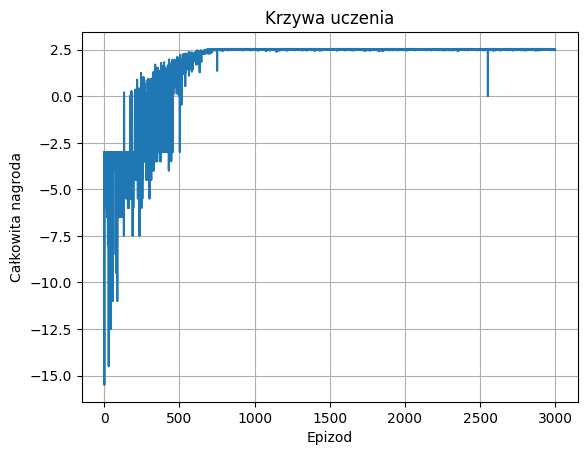

🎯 Agent dotarł do celu!
🔁 Długość ścieżki: 47
📍 Pozycja końcowa agenta: [19, 19]
🎯 Czy osiągnięto cel: True
Długość znalezionej ścieżki: 47


In [11]:
from maze_env import MazeEnv
from agent import QLearningAgent

env = MazeEnv(size=20)
agent = QLearningAgent(env)

agent.train(episodes=3000)
agent.plot_learning_curve()

path = agent.find_best_path()
print(f"Długość znalezionej ścieżki: {len(path)}")


---
## 5. Tryb graficzny

W projekcie zaimplementowano tryb graficzny za pomocą biblioteki **pygame**, który wizualizuje działanie agenta w labiryncie.

Środowisko przedstawia:
- początkową pozycję agenta (ikona `start`),
- cel (ikona `goal`),
- ściany (`wall`),
- strefy karne (`zombie`),
- agenta (Mario), który porusza się animowanymi krokami.

Ruch agenta oparty jest na ścieżce znalezionej po treningu (`agent.find_best_path()`), dzięki czemu możemy obserwować jego optymalną trasę do celu.

Aby uruchomić graficzną symulację, wystarczy uruchomić plik `gui.py`. Jeśli plik `q_table.npy` nie istnieje, użytkownik zostaje poinformowany o konieczności wcześniejszego treningu agenta.

### 📄 Kod gui.py:

In [13]:
import pygame
import sys
import numpy as np
import time

from maze_env import MazeEnv
from agent import QLearningAgent

CELL_SIZE = 35
MARGIN = 2
FPS = 6  # tempo animacji

pygame.init()

# Wczytaj obrazy
def load_img(name):
    return pygame.transform.scale(pygame.image.load(f"images/{name}"), (CELL_SIZE, CELL_SIZE))

# Klasyczna animacja Mario
MARIO_FRAMES = [
    load_img("mario_1.png"),
    load_img("mario_2.png"),
    load_img("mario_3.png"),
]

START_IMG = load_img("start1.jpg")
GOAL_IMG = load_img("goal1.gif")
WALL_IMG = load_img("brick1.jpg")
GRASS_IMG = load_img("floor.avif")
ZOMBIE_IMG = load_img("mob.jpg")

def draw_grid(screen, env, agent_pos, frame_index):
    for y in range(env.size):
        for x in range(env.size):
            rect = pygame.Rect(
                x * (CELL_SIZE + MARGIN),
                y * (CELL_SIZE + MARGIN),
                CELL_SIZE,
                CELL_SIZE
            )

            screen.blit(GRASS_IMG, rect)

            if [y, x] == [0, 0]:
                screen.blit(START_IMG, rect)
            elif [y, x] == env.goal_pos:
                screen.blit(GOAL_IMG, rect)
            elif [y, x] == agent_pos:
                screen.blit(MARIO_FRAMES[frame_index], rect)
            elif [y, x] in env.penalty_points:
                screen.blit(ZOMBIE_IMG, rect)
            elif env.maze[y, x] == 1:
                screen.blit(WALL_IMG, rect)

def main():
    env = MazeEnv(size=20)
    agent = QLearningAgent(env)

    try:
        agent.q_table = np.load("q_table.npy")
    except FileNotFoundError:
        print("❌ Brak pliku q_table.npy – uruchom train.py.")
        sys.exit()

    path = agent.find_best_path()

    screen_size = env.size * (CELL_SIZE + MARGIN)
    screen = pygame.display.set_mode((screen_size, screen_size))
    pygame.display.set_caption("🍄 Mario Maze Agent")
    clock = pygame.time.Clock()

    step = 0
    frame_index = 0
    frame_timer = 0

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        if step < len(path):
            agent_pos = path[step]
            step += 1
        else:
            time.sleep(2)
            pygame.quit()
            sys.exit()

        frame_timer += 1
        if frame_timer >= 5:
            frame_index = (frame_index + 1) % len(MARIO_FRAMES)
            frame_timer = 0

        screen.fill((0, 0, 0))
        draw_grid(screen, env, agent_pos, frame_index)
        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


🎯 Agent dotarł do celu!
🔁 Długość ścieżki: 47
📍 Pozycja końcowa agenta: [19, 19]
🎯 Czy osiągnięto cel: True


SystemExit: 

## 7. Wnioski

-  Agent nauczył się skutecznie rozwiązywać labirynt.
-  Strategia Q-learning z malejącym współczynnikiem `epsilon` umożliwiła stopniowe przejście od losowego działania do wykorzystania optymalnej strategii.
-  Graficzne przedstawienie w `pygame` znacząco ułatwiło walidację wyników i zrozumienie działania agenta.
-  Środowisko zostało zaprojektowane modularnie, co ułatwia przyszłe modyfikacje i eksperymenty (np. z innymi algorytmami, jak DQN).

### Możliwe rozszerzenia:
- 🔄 Dynamiczne przeszkody (ruchome zombie),
- 🌐 Generowanie losowych labiryntów,
- 🧠 Wprowadzenie modelu z ciągłą przestrzenią obserwacji i nieliniową aproksymacją funkcji Q.

---

## 8. Pliki projektu

| Plik            | Opis                                      |
|------------------|---------------------------------------------|
| `maze_env.py`    | Implementacja środowiska labiryntu          |
| `agent.py`       | Agent uczący się za pomocą Q-learning       |
| `train.py`       | Skrypt treningowy i wykres krzywej uczenia  |
| `gui.py`         | Tryb graficzny z użyciem pygame             |
| `q_table.npy`    | Zapisana tablica Q po treningu              |